thicknesses: [132.22476335   7.84221203], roughnesses: [1.24247987 3.71923052], slds: [ 11.60386413 101.94614468]


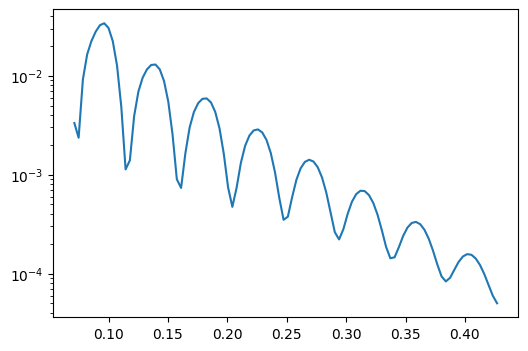

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model_fused import PhysicsLayer

from reflecto.simulator.simulator import XRRSimulator, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 1.0   # degree
tth_max: float = 6.0
q_min: float = tth2q_wavelen(tth_min, wavelen)  # (1/Å)
q_max: float = tth2q_wavelen(tth_max, wavelen)
q_n: int = 100
qs: np.ndarray = np.linspace(q_min, q_max, q_n)

xrr_simulator = XRRSimulator(qs, 2, 1)
thicknesses, roughnesses, slds, refl = next(xrr_simulator.make_params_refl())

print(f"thicknesses: {thicknesses}, roughnesses: {roughnesses}, slds: {slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [ ]:
refl_tensor = torch.tensor(np.log10(refl), dtype=torch.float32).unsqueeze(0)  # (1, Q)
qs_tensor = torch.tensor(qs, dtype=torch.float32)

print("실제 파라미터:")
print(f"두께: {thicknesses} Å")
print(f"거칠기: {roughnesses} Å")
print(f"SLD: {slds}")

✅ 실제 파라미터:
   두께: [132.22476335   7.84221203] Å
   거칠기: [1.24247987 3.71923052] Å
   SLD: [ 11.60386413 101.94614468]


In [6]:
# 주피터 셀 3: PhysicsLayer 실행
# PhysicsLayer 초기화
physics_layer = PhysicsLayer(qs_tensor, n_layers=2, confidence_threshold=0.1)

# 추정 실행
with torch.no_grad():
    est_thickness, confidence = physics_layer(refl_tensor)

# 결과 출력
print("\nPhysicsLayer 추정 결과:")
print(f"신뢰도: {confidence[0].item():.3f}")
print(f"추정 두께: {est_thickness[0].numpy()} Å")
print(f"실제 두께: {thicknesses} Å")
print(f"MAE: {np.mean(np.abs(est_thickness[0].numpy()[:len(thicknesses)] - thicknesses)):.2f} Å")

# 성공 여부
if confidence[0] > 0.1:
    print("신뢰할 만한 추정")
else:
    print("신뢰도 낮음")

2025-11-13 00:54:04,635 - INFO - 
2025-11-13 00:54:04,637 - INFO - Batch Summary: Success rate = 0.00%
2025-11-13 00:54:04,640 - INFO - ============================================================


PhysicsLayer 추정 결과:
신뢰도: 0.000
추정 두께: [0. 0.] Å
실제 두께: [132.22476335   7.84221203] Å
MAE: 70.03 Å
신뢰도 낮음


In [ ]:
# 주피터 셀 4: 신호 처리 과정 시각화 (FFT)
# FFT 계산 (PhysicsLayer 내부 과정)
R_log = np.log10(refl)
R_original = 10 ** R_log

# Savitzky-Golay 필터
window_len = min(len(R_log), 51)
R_smooth = signal.savgol_filter(R_log, window_length=window_len, polyorder=4, mode='interp')
R_savgol = R_original / (10 ** R_smooth)
R_savgol = R_savgol / (R_savgol[0] + 1e-12) * R_original.max()

# FFT
N = len(R_savgol)
dq = qs[1] - qs[0]
w = signal.windows.hamming(N)
yf = 2 / N * np.abs(fft(w * R_savgol / np.mean(w), n=10000))
xf = fftfreq(10000, d=dq)[:5000]
x_fft = xf * 2 * np.pi

# 피크 검출
from scipy.signal import argrelmax

upper_idx = np.searchsorted(x_fft, 200.0)
detected_peaks = []
for order in [50, 30, 20, 10]:
    idx_max = argrelmax(yf[:upper_idx], order=order)[0]
    if len(idx_max) > 0:
        peaks = x_fft[idx_max]
        heights = yf[idx_max]
        strong_peaks = peaks[heights > 0.005]
        if len(strong_peaks) > 0:
            detected_peaks = strong_peaks
            break

# 플롯
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# 1. 반사율 곡선
axes[0].plot(qs, R_original, 'b-', linewidth=1.5, label='Simulated Reflectivity')
axes[0].set_xlabel('q (1/Å)')
axes[0].set_ylabel('R')
axes[0].set_title('XRR Reflectivity Curve')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# 2. FFT 및 피크
axes[1].plot(x_fft, yf, 'g-', linewidth=1, label='FFT Amplitude')
if len(detected_peaks) > 0:
    peak_idx = [np.argmin(np.abs(x_fft - p)) for p in detected_peaks]
    axes[1].plot(detected_peaks, yf[peak_idx], 'ro', markersize=8, label=f'Detected Peaks ({len(detected_peaks)})')

axes[1].set_xlabel('Frequency (1/thickness)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'FFT Analysis (Confidence: {confidence[0].item():.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 주피터 셀 5: 두께 비교 바 차트
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

layers = np.arange(len(thicknesses))
width = 0.35

# 실제 vs 추정
real_bar = ax.bar(layers - width/2, thicknesses, width, label='Real Thickness', color='steelblue')
est_values = est_thickness[0][:len(thicknesses)].cpu().numpy()
est_bar = ax.bar(layers + width/2, est_values, width, label='Physics Est.', color='coral', alpha=0.8)

# 신뢰도 표시
ax.text(0.02, 0.98, f'Confidence: {confidence[0].item():.3f}\nMAE: {np.mean(np.abs(est_values - thicknesses)):.2f} Å',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Layer Index')
ax.set_ylabel('Thickness (Å)')
ax.set_title('Real vs PhysicsLayer Estimation')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.show()

In [4]:
from dataset_fused import FusedDatasetH5

config = {
    "exp_name": "exp04_physics_fused",
    "h5_path": r"D:\data\XRR_AI\xrr_data.h5",
    "checkpoint_dir": r"D:\data\XRR_AI",
    "epochs": 30,
    "batch_size": 32,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "val_ratio": 0.2,
    "save_every": 5,
    "physics_weight": 0.5,    # 물리 모델 가중치
    "norm_ranges": {
        "thickness": [0.0, 200.0],
        "roughness": [0.0, 10.0],
        "sld": [0.0, 140.0]
    }
}

dataset = FusedDatasetH5(config["h5_path"], norm_ranges=config["norm_ranges"])
print(f"Thickness: min={dataset.thickness_range[0]}, max={dataset.thickness_range[1]}")

Thickness: min=0.0, max=200.0
